In [12]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

In [2]:
file_path = "C:\\Users\\alan\\Medical Image Project\\BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx"

df = pd.read_excel(file_path)
df

,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Echogenicity,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,BIRADS,Verification,Diagnosis,Classification
0,1,case001.png,case001_tumor.png,NaN,0.007812,57,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,...,heterogeneous,shadowing,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),2,confirmed by follow-up care,not applicable,benign
1,2,case002.png,case002_tumor.png,NaN,0.006462,not available,homogeneous: fat,not available,not available,oval,...,hypoechoic,no,no,no,no,Dysplasia&Fibroadenoma,4b,confirmed by biopsy,Intramammary lymph node,benign
2,3,case003.png,case003_tumor.png,NaN,0.006944,56,heterogeneous: predominantly fat,no,nipple discharge,oval,...,hyperechoic,no,no,no,no,Duct filled with thick fluid&Intraductal papil...,4a,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,benign
3,4,case004.png,case004_tumor.png,NaN,0.007812,43,homogeneous: fibroglandular,no,no,round,...,hypoechoic,no,no,no,no,Cyst filled with thick fluid,3,confirmed by follow-up care,not applicable,benign
4,5,case005.png,case005_tumor.png,NaN,0.007812,67,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,...,complex cystic/solid,enhancement,no,no,no,Suspicion of malignancy&Intraductal papilloma,4b,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,malignant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,case252.png,case252_tumor.png,NaN,0.006944,18,homogeneous: fibroglandular,palpable,no,oval,...,hypoechoic,no,no,no,no,Fibroadenoma,4a,confirmed by biopsy,Fibroadenoma,benign
252,253,case253.png,case253_tumor.png,NaN,0.007812,64,homogeneous: fat,palpable&breast scar,family history of breast/ovarian cancer,oval,...,anechoic,enhancement,no,no,yes,Fat necrosis&Breast scar (surgery),2,confirmed by follow-up care,not applicable,benign
253,254,case254.png,case254_tumor.png,NaN,0.007812,57,heterogeneous: predominantly fat,no,no,irregular,...,hypoechoic,shadowing,no,no,no,Suspicion of malignancy,5,confirmed by biopsy,Invasive carcinoma of no special type (NST)&Du...,malignant
254,255,case255.png,case255_tumor.png,NaN,0.006944,42,heterogeneous: predominantly fibroglandular,palpable,family history of breast/ovarian cancer,irregular,...,heterogeneous,shadowing,no,intraductal,no,Suspicion of malignancy&Mastitis,4c,confirmed by biopsy,Ductal carcinoma in situ (DCIS),malignant


In [3]:
# Preprocessing
columns_to_drop = ["Image_filename", "Mask_tumor_filename","Mask_other_filename", "Pixel_size", "Verification","BIRADS"]
new_df = df.drop(columns=columns_to_drop)


# handling missing Age
new_df_filtered = new_df[new_df['Age'] != 'not available']
new_df_filtered['Age'] = pd.to_numeric(new_df_filtered['Age'])
age_mean_corrected = new_df_filtered['Age'].mean()

# Replace 'not available' with the calculated mean age in the original new_df
new_df['Age'] = new_df['Age'].replace('not available', age_mean_corrected)
new_df['Age'] = pd.to_numeric(new_df['Age'], errors='coerce')
new_df['Age'] = new_df['Age'].astype(int)

# Drop rows where the 'Classification' column does not contain 'benign' or 'malignant'
final_df = new_df[(new_df['Classification'] == 'benign') | (new_df['Classification'] == 'malignant')]

label = final_df['Classification']
final_df = final_df.drop('Classification', axis=1)
final_df

C:\Users\alan\AppData\Local\Temp\ipykernel_9948\2673460380.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_filtered['Age'] = pd.to_numeric(new_df_filtered['Age'])


,CaseID,Age,Tissue_composition,Signs,Symptoms,Shape,Margin,Echogenicity,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,Diagnosis
0,1,57,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,not circumscribed - indistinct,heterogeneous,shadowing,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),not applicable
1,2,53,homogeneous: fat,not available,not available,oval,not circumscribed - indistinct,hypoechoic,no,no,no,no,Dysplasia&Fibroadenoma,Intramammary lymph node
2,3,56,heterogeneous: predominantly fat,no,nipple discharge,oval,circumscribed,hyperechoic,no,no,no,no,Duct filled with thick fluid&Intraductal papil...,Usual ductal hyperplasia (UDH)&Pseudoangiomato...
3,4,43,homogeneous: fibroglandular,no,no,round,circumscribed,hypoechoic,no,no,no,no,Cyst filled with thick fluid,not applicable
4,5,67,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,circumscribed,complex cystic/solid,enhancement,no,no,no,Suspicion of malignancy&Intraductal papilloma,Encapsulated papillary carcinoma&Ductal carcin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,18,homogeneous: fibroglandular,palpable,no,oval,circumscribed,hypoechoic,no,no,no,no,Fibroadenoma,Fibroadenoma
252,253,64,homogeneous: fat,palpable&breast scar,family history of breast/ovarian cancer,oval,circumscribed,anechoic,enhancement,no,no,yes,Fat necrosis&Breast scar (surgery),not applicable
253,254,57,heterogeneous: predominantly fat,no,no,irregular,not circumscribed - microlobulated&indistinct,hypoechoic,shadowing,no,no,no,Suspicion of malignancy,Invasive carcinoma of no special type (NST)&Du...
254,255,42,heterogeneous: predominantly fibroglandular,palpable,family history of breast/ovarian cancer,irregular,not circumscribed - microlobulated&indistinct,heterogeneous,shadowing,no,intraductal,no,Suspicion of malignancy&Mastitis,Ductal carcinoma in situ (DCIS)


In [4]:
# NLP feature extraction

non_numerical_columns = [col for col in final_df.columns if final_df[col].dtype == 'object' and col not in ['CaseID', 'Age']]
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100, stop_words='english')

for column in non_numerical_columns:
    # Convert column to string
    column_as_string = final_df[column].astype(str).fillna('')
    tfidf_matrix = tfidf_vectorizer.fit_transform(column_as_string)
    
    feature_names = [f"{column}_{word}" for word in tfidf_vectorizer.get_feature_names_out()]
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    
    # Concatenate TF-IDF 
    if 'final_numerical_df' in locals():
        final_numerical_df = pd.concat([final_numerical_df, tfidf_df], axis=1)
    else:
        final_numerical_df = tfidf_df.copy()

        
final_numerical_df = pd.concat([final_df[['CaseID', 'Age']].reset_index(drop=True), final_numerical_df.reset_index(drop=True)], axis=1)

# Check the shape
final_numerical_df.shape, final_numerical_df.head()


# Assuming tfidf_vectorizer was fitted on the training data
# Use it to transform the test data without refitting
tfidf_matrix_test = tfidf_vectorizer.transform(column_as_string_test)



((252, 156),
    CaseID  Age  Tissue_composition_available  Tissue_composition_fat  \
 0       1   57                           0.0                0.636203   
 1       2   53                           0.0                0.636732   
 2       3   56                           0.0                0.636203   
 3       4   43                           0.0                0.000000   
 4       5   67                           0.0                0.636732   
 
    Tissue_composition_fibroglandular  Tissue_composition_heterogeneous  \
 0                           0.000000                          0.545548   
 1                           0.000000                          0.000000   
 2                           0.000000                          0.545548   
 3                           0.640618                          0.000000   
 4                           0.000000                          0.000000   
 
    Tissue_composition_homogeneous  Tissue_composition_lactating  \
 0                        0

In [5]:
final_numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Columns: 156 entries, CaseID to Diagnosis_usual
dtypes: float64(154), int32(1), int64(1)
memory usage: 306.3 KB


In [6]:
# split the data
X = final_numerical_df

encoder = LabelEncoder()
y = encoder.fit_transform(label)

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((226, 156), (26, 156), (226,), (26,))

In [7]:
# model Building

input_shape = X_train.shape[1]

# Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape,)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               20096     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,465
Trainable params: 30,465
Non-traina

In [8]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=50,  
                    batch_size=4,  
                    validation_split=0.2,  
                    verbose=1)
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}")


Epoch 1/50
45/45 [==============================] - 1s 6ms/step - loss: 2.5282 - accuracy: 0.4722 - val_loss: 0.6881 - val_accuracy: 0.5000
Epoch 2/50
45/45 [==============================] - 0s 2ms/step - loss: 1.1232 - accuracy: 0.5167 - val_loss: 0.6420 - val_accuracy: 0.6522
Epoch 3/50
45/45 [==============================] - 0s 2ms/step - loss: 0.7557 - accuracy: 0.5556 - val_loss: 0.7475 - val_accuracy: 0.5870
Epoch 4/50
45/45 [==============================] - 0s 2ms/step - loss: 0.7845 - accuracy: 0.6056 - val_loss: 0.6886 - val_accuracy: 0.5870
Epoch 5/50
45/45 [==============================] - 0s 2ms/step - loss: 0.9203 - accuracy: 0.5056 - val_loss: 0.6617 - val_accuracy: 0.5870
Epoch 6/50
45/45 [==============================] - 0s 2ms/step - loss: 0.7057 - accuracy: 0.5833 - val_loss: 0.6523 - val_accuracy: 0.5870
Epoch 7/50
45/45 [==============================] - 0s 2ms/step - loss: 0.7390 - accuracy: 0.5833 - val_loss: 0.6482 - val_accuracy: 0.5870
Epoch 8/50
45/45 [==

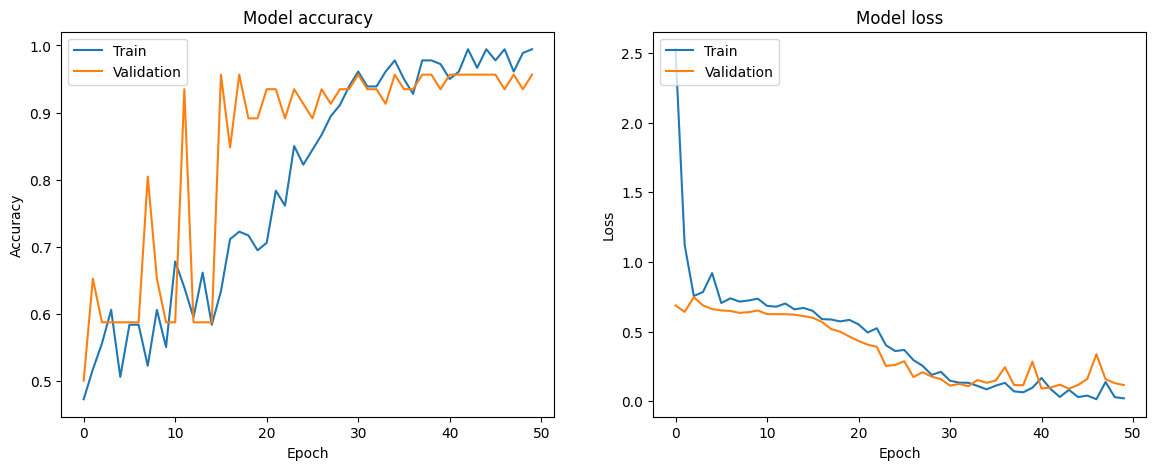

In [9]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [10]:
model.save('C:/Users/alan/Medical Image Project/NLP model.h5')


In [14]:
dir = 'C:/Users/alan/Medical Image Project'
nlp_model = load_model(dir +'/NLP_model.h5')

In [15]:
text_predictions = nlp_model.predict(X_test)


ValueError: in user code:

    File "G:\anaconda3\lib\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "G:\anaconda3\lib\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "G:\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "G:\anaconda3\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "G:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "G:\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_28" is incompatible with the layer: expected shape=(None, 2809), found shape=(None, 156)
